In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease


In [2]:
df = pd.read_csv('data/data/breast_cancer.csv')
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [3]:
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

# visualize bagaimana PCA dapat membantu kita

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, whiten=True) # whiten untuk scaling
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

sns.scatterplot(X_train_pca[:, 0], X_train_pca[:, 1], hue=y_train)


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

C:\Users\akmal\AppData\Local\Temp\ipykernel_22132\4154973975.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


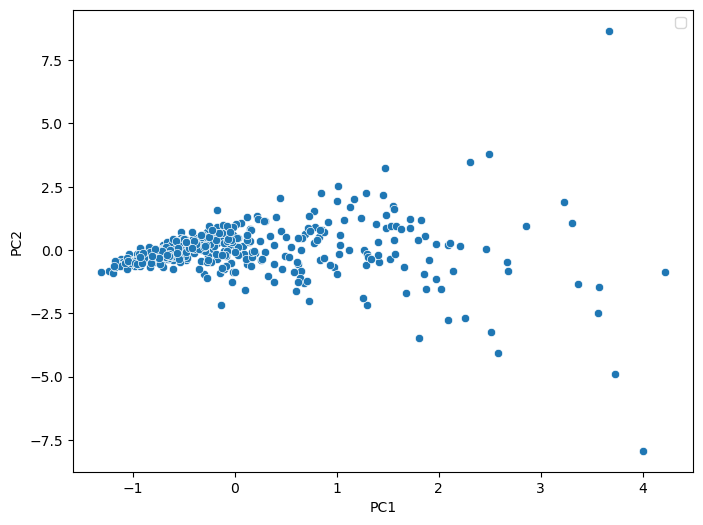

In [10]:
import pandas as pd
df_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])

# If you have target labels (y_train), you can use them to color the points
df_pca['Target'] = y_train  # Assuming y_train has your labels

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2')

plt.legend()
plt.show()

# Training

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Real, Integer

In [12]:


preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("pca", PCA()),
    ("algo", SVC(max_iter=500))
])

parameter = {
    "pca__n_components": Integer(1, 30),
    "pca__whiten": [True, False],
    "algo__gamma": Real(low=-3, high=3, prior="log-uniform"),
    "algo__C": Real(low=-3, high=3, prior="log-uniform")
}

model = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 3.907967156822884, 'algo__gamma': 0.008632008168602547, 'pca__n_components': 19, 'pca__whiten': True}
0.9736263736263736 0.9582607180202162 0.9736842105263158


# Bagaimana menentukan n_components -> Cumulative Explained Variance

In [13]:
pca = PCA().fit(X_train)

Text(0, 0.5, 'cumulative explained varience')

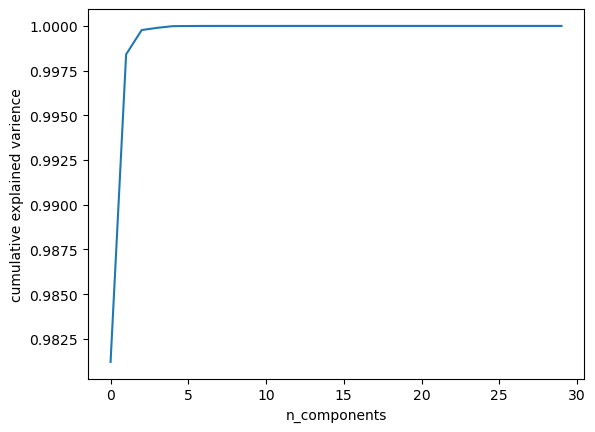

In [15]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('n_components')
plt.ylabel('cumulative explained varience')

ternyata data yang kita punya sudah cukup bagus sumbu y menunjukan seberapa banyak informasi yang hilang berdasarkan sumbu x

In [16]:


preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("pca", PCA(n_components=5, whiten=True)),
    ("algo", SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\akmal\anaconda3\envs\jcopdl\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'algo__C': 98.77700294007921, 'algo__gamma': 0.01879466824163846}
0.9692307692307692 0.9626612059951202 0.9649122807017544
